In [1]:
from cortexlib.mouse import CortexlabMouse

mouse = CortexlabMouse()

null_srv_all_neurons = mouse.compute_null_all_neurons(n_shuffles=100)
real_srv_all_neurons = mouse.compute_real_srv_all_neurons()
reliable_neuron_indices = mouse.get_reliable_neuron_indices(
            null_srv_all_neurons, real_srv_all_neurons, percentile_threshold=99)
neural_responses_mean, neural_responses, _ = mouse.get_responses_for_reliable_neurons(reliable_neuron_indices, real_srv_all_neurons, num_neurons=500)

In [2]:
from cortexlib.images import CortexlabImages

images = CortexlabImages()
image_dataset = images.load_images_shown_to_mouse(mouse.stimulus_ids)

In [3]:
from cortexlib.simclr import PreTrainedSimCLRModel

simclr = PreTrainedSimCLRModel()
simclr_features, _ = simclr.extract_features(image_dataset)

Already downloaded pretrained model: https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/SimCLR.ckpt


  0%|          | 0/25 [00:00<?, ?it/s]

In [4]:
from cortexlib.predictor import NeuralResponsePredictor

results = []

for layer, feats in simclr_features.items():
    for n_pcs in [None, 10, 20, 50, 100, 200, 300, 400, 500]:
        predictor = NeuralResponsePredictor(reduce_image_representation_to_n_pcs=n_pcs, neural_data_pc_index=0)
        r_squared = predictor.compute_r_squared(feats, neural_responses)
        fev = predictor.compute_fev(feats, neural_responses)

        results.append({
            'layer': layer,
            'n_pcs': n_pcs,
            'test_r2': r_squared['test_r2'],
            'mean_fev': fev['mean_fev']
        })

In [5]:
from cortexlib.utils.file import write_json_file

write_json_file(results, f'./results/simclr_feats_pcs_to_pc1_neural_data.json')

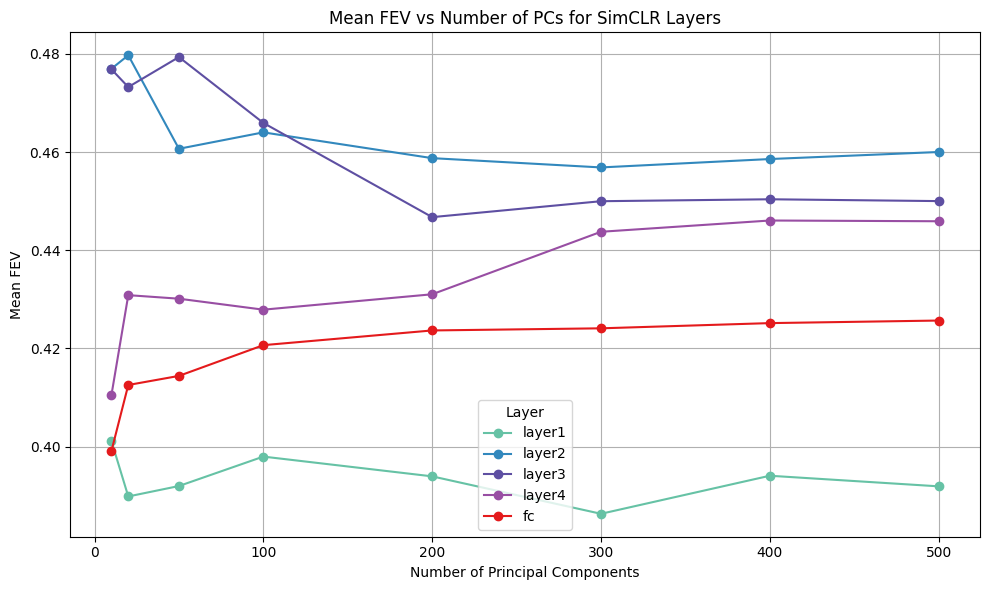

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from cortexlib.utils.plotting import simclr_colors

results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))

for layer in results_df['layer'].unique():
    layer_results = results_df[results_df['layer'] == layer]
    plt.plot(layer_results['n_pcs'], layer_results['mean_fev'], marker='o', color=simclr_colors[layer], label=layer)

plt.xlabel('Number of Principal Components')
plt.ylabel('Mean FEV')
plt.title('Mean FEV vs Number of PCs for SimCLR Layers')
plt.legend(title='Layer')
plt.grid(True)
plt.tight_layout()
plt.show()